# t-SNE plots 
```shell
conda install anaconda::scikit-learn
```

In [51]:
from dataset_analysis.lib.tSEN_utils import merg_tSNE
import pandas as pd
import os
from dataset_analysis.lib.tSEN_utils import show_tSNE, show_tSNE_samples
from dataset_analysis.lib.tSEN_utils import sampling, omit_outline

base_path = './result/dataset_analysis'
number_vector = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

Depredicated

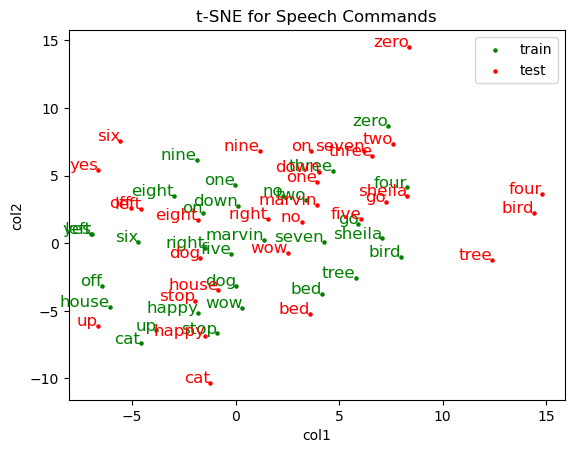

In [52]:
sc_full = pd.read_csv(os.path.join(base_path, 'speech-commands', 'speech-commands_full_tsen.csv'))
sc_train = sc_full[sc_full['source'] == 'train']
sc_test = sc_full[sc_full['source'] == 'test']
sc_train = merg_tSNE(df=sc_train, mode='mean')
sc_test = merg_tSNE(df=sc_test, mode='mean')
# sc_train = sc_train[sc_train['label'].isin(number_vector)]
# sc_test = sc_test[sc_test['label'].isin(number_vector)]
show_tSNE(title='t-SNE for Speech Commands', train_df=sc_train, test_df=sc_test)

Depredicated

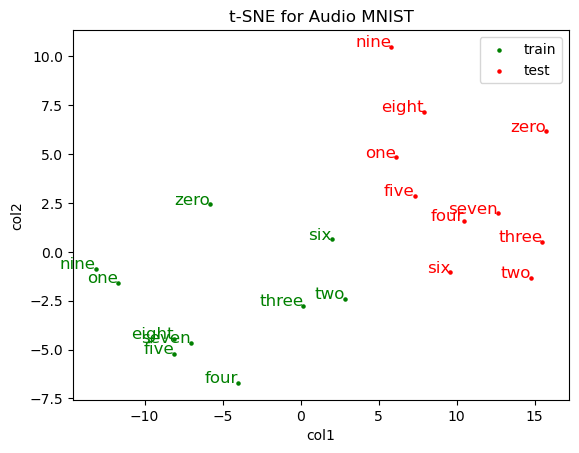

In [53]:
mnist_full = pd.read_csv(os.path.join(base_path, 'audio-mnist', 'audio-mnist_full_tsen.csv'))
mnist_train = mnist_full[mnist_full['source'] == 'train']
mnist_test = mnist_full[mnist_full['source'] == 'test']
mnist_train = merg_tSNE(df=mnist_train, mode='mean')
mnist_test = merg_tSNE(df=mnist_test, mode='mean')
show_tSNE(title='t-SNE for Audio MNIST', train_df=mnist_train, test_df=mnist_test)

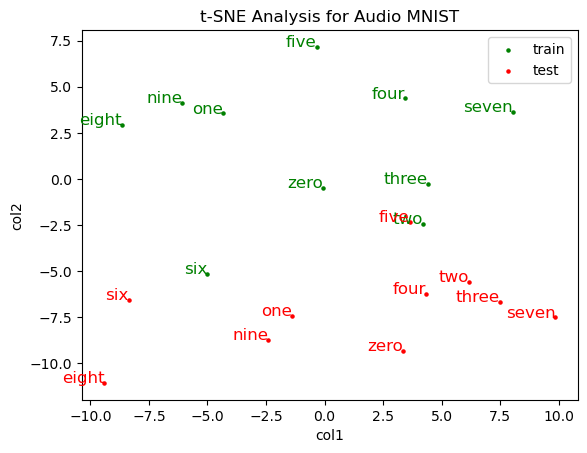

In [54]:
mnist_full = pd.read_csv(os.path.join(base_path, 'audio-mnist', 'audio-mnist_full_noreduced_tsen.csv'))
mnist_train = mnist_full[mnist_full['source'] == 'train']
mnist_test = mnist_full[mnist_full['source'] == 'test']
mnist_train = merg_tSNE(df=mnist_train, mode='mean')
mnist_test = merg_tSNE(df=mnist_test, mode='mean')
show_tSNE(title='t-SNE Analysis for Audio MNIST', train_df=mnist_train, test_df=mnist_test)

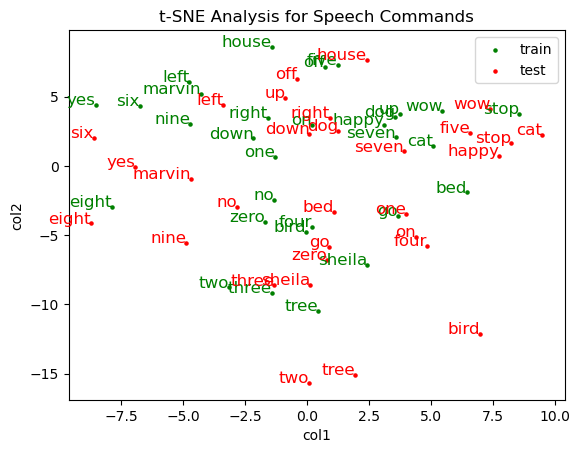

In [55]:
sc_full = pd.read_csv(os.path.join(base_path, 'speech-commands', 'speech-commands_full_noreduced_tsen.csv'))
sc_train = sc_full[sc_full['source'] == 'train']
sc_test = sc_full[sc_full['source'] == 'test']
sc_train = merg_tSNE(df=sc_train, mode='mean')
sc_test = merg_tSNE(df=sc_test, mode='mean')
# sc_train = sc_train[sc_train['label'].isin(number_vector)]
# sc_test = sc_test[sc_test['label'].isin(number_vector)]
show_tSNE(title='t-SNE Analysis for Speech Commands', train_df=sc_train, test_df=sc_test)

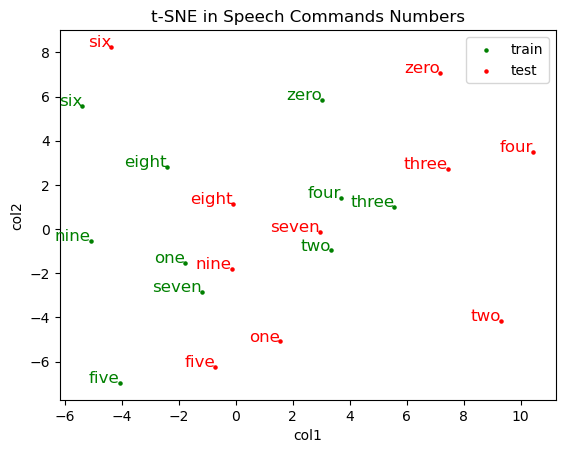

In [56]:
scn_full = pd.read_csv(os.path.join(base_path, 'speech-commands-numbers', 'speech-commands-numbers_full_noreduced_tsen.csv'))
scn_train = scn_full[scn_full['source'] == 'train']
scn_test = scn_full[scn_full['source'] == 'test']
scn_train = merg_tSNE(df=scn_train, mode='mean')
scn_test = merg_tSNE(df=scn_test, mode='mean')
show_tSNE(title='t-SNE in Speech Commands Numbers', train_df=scn_train, test_df=scn_test)

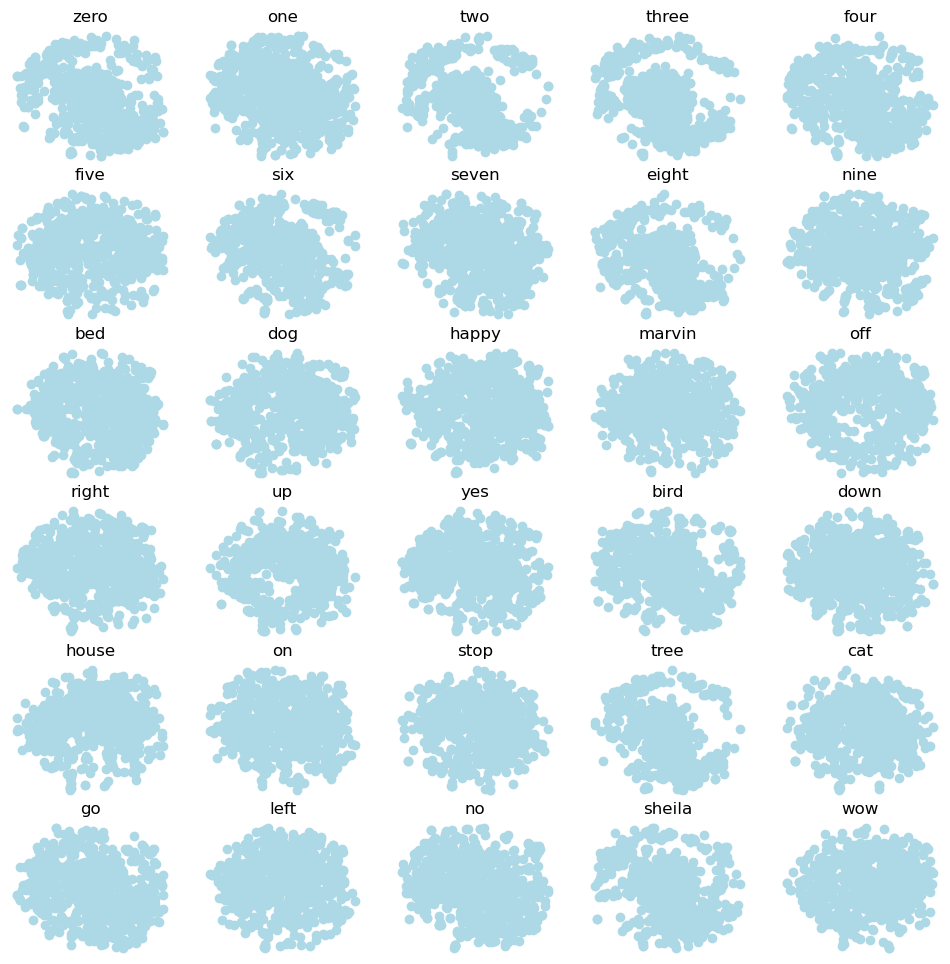

In [57]:
from dataset_analysis.lib.tSEN_utils import show_by_label
sc_full = pd.read_csv(os.path.join(base_path, 'speech-commands', 'speech-commands_full_noreduced_tsen.csv'))
sc_train = sc_full[sc_full['source'] == 'train']
sc_test = sc_full[sc_full['source'] == 'test']
show_by_label(df=sc_train)

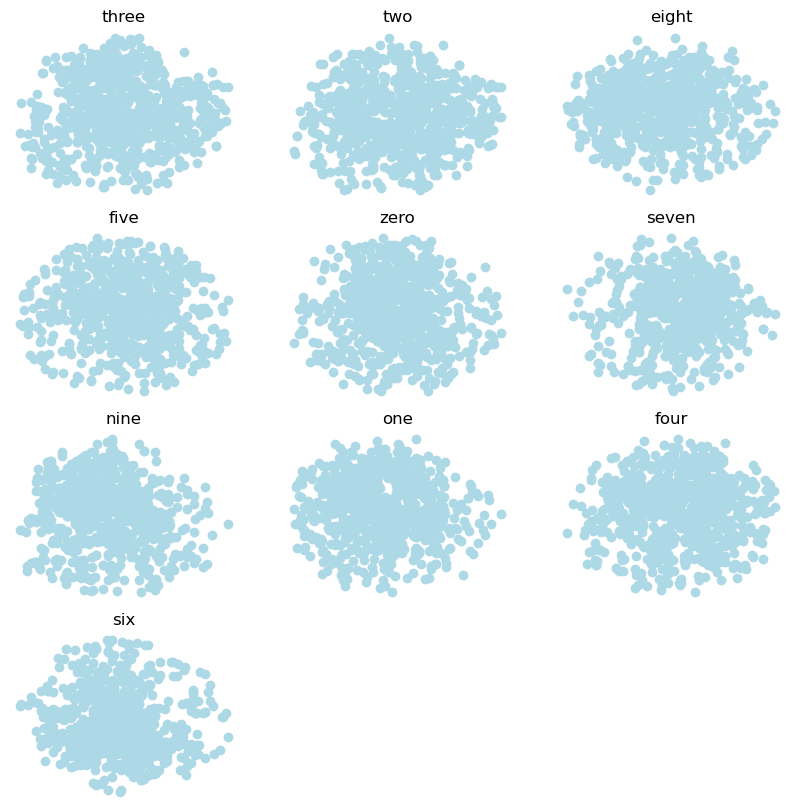

In [58]:
mnist_full = pd.read_csv(os.path.join(base_path, 'audio-mnist', 'audio-mnist_full_noreduced_tsen.csv'))
mnist_train = mnist_full[mnist_full['source'] == 'train']
mnist_test = mnist_full[mnist_full['source'] == 'test']
show_by_label(df=mnist_train, figheight=10, figwidth=10)

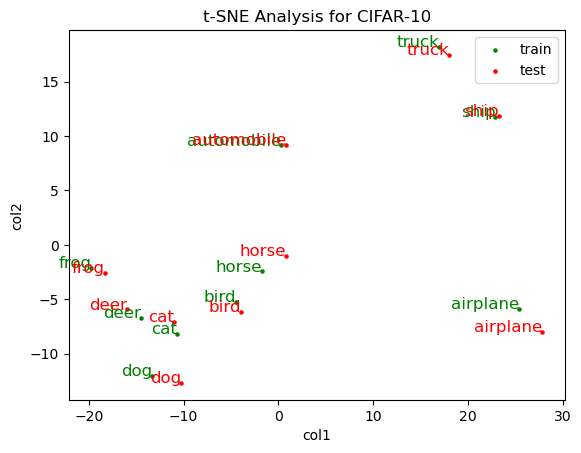

In [59]:
cifar_full = pd.read_csv(os.path.join(base_path, 'cifar-10', 'cifar-10_full_noreduced_tsen.csv'))
cifar_train = cifar_full[cifar_full['source'] == 'train']
cifar_test = cifar_full[cifar_full['source'] == 'test']
cifar_train = merg_tSNE(df=cifar_train)
cifar_test = merg_tSNE(df=cifar_test)
show_tSNE(title='t-SNE Analysis for CIFAR-10', train_df=cifar_train, test_df=cifar_test)

/Users/andyshao/git/Test-time-Adaptation-in-AC/dataset_analysis/lib/tSEN_utils.py:125: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret = pd.concat([ret, tmp], axis=0, ignore_index=True, copy=True)
/Users/andyshao/git/Test-time-Adaptation-in-AC/dataset_analysis/lib/tSEN_utils.py:132: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ret = pd.concat([ret, sub_df], axis=0, ignore_index=True, copy=True)
/Users/andyshao/git/Test-time-Adaptation-in-AC/dataset_analysis/lib/tSEN_utils.py:125: FutureWarnin

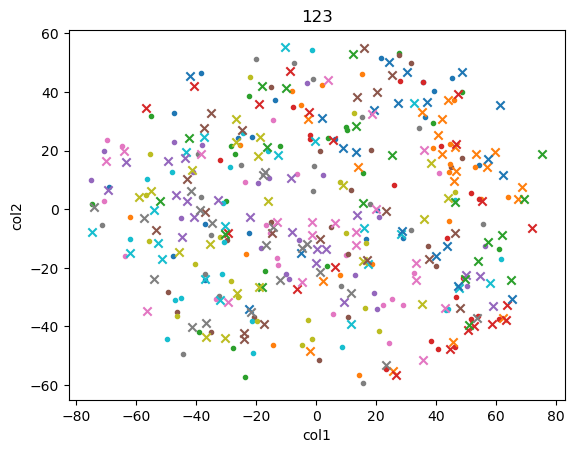

In [60]:
cifar_full = pd.read_csv(os.path.join(base_path, 'cifar-10', 'cifar-10_full_noreduced_tsen.csv'))
cifar_train = cifar_full[cifar_full['source'] == 'train']
cifar_test = cifar_full[cifar_full['source'] == 'test']
cifar_train = omit_outline(df=cifar_train)
cifar_train = sampling(df=cifar_train, max_size=20)
cifar_test = omit_outline(df=cifar_test)
cifar_test = sampling(df=cifar_test, max_size=20)
colors = {
    'truck':'#1f77b4', 'ship':'#ff7f0e', 'automobile':'#2ca02c', 'airplane':'#d62728', 
    'frog':'#9467bd', 'horse':'#8c564b', 'bird':'#e377c2', 'deer':'#7f7f7f', 
    'dog':'#bcbd22', 'cat':'#17becf'
}
show_tSNE_samples(title='123', train_df=cifar_train, test_df=cifar_test, colors=colors)